# Week 1: Binary Logistic Regression Classifier Build From Iris Data
Init:   September 28 2019

Update: 10/8/19

Goal: Build a binary logistic classifier from the iris.csv data using sklearn.
Stretch Goal: Build a tri-class classifier

We will use the lbfgs solver with  no regression done at all. We want to have no regression as we only want to deal with the parameters and not the hyper-parameters.

## Running Binary Classifier

Here we import the iris.csv dataset

In [1]:
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

# Import Dataset
filename = "iris.csv"
df = pd.read_csv(filename, sep='\s*,\s*',engine = 'python')

# Separate Dataset into each
setosa_set = df[df["class"]=="Iris-setosa"]
versicolor_set = df[df["class"]=="Iris-versicolor"]
virginica_set = df[df["class"]=="Iris-virginica"]

# Separate each dataset into training and testing data
total_train,total_test = train_test_split(df, random_state=42, test_size=0.3, shuffle=True)
setosa_train, setosa_test = train_test_split(setosa_set, random_state=42, test_size=0.3, shuffle=True)
versicolor_train, versicolor_test = train_test_split(versicolor_set, random_state=42, test_size=0.3, shuffle=True)
virginica_train, virginica_test = train_test_split(virginica_set, random_state=42, test_size=0.3, shuffle=True)

## Run Logistic Fitting On Iris Data
We use pandas to build dataframes and SKlearn's logistic regression based on string based classes

In [2]:
# Logistic Model Fitting
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Split training/test data to input and output
cols = ['sepal length','sepal width', 'petal length', 'petal width']
y_val = 'class'
# Train Data
x_setosa_train = setosa_train[cols]
y_setosa_train = setosa_train[y_val]
x_versicolor_train = versicolor_train[cols]
y_versicolor_train = versicolor_train[y_val]

"""Running Simulation for 2 class case"""

x_train = x_setosa_train.append(x_versicolor_train)
y_train = y_setosa_train.append(y_versicolor_train)

x_test = setosa_test[cols].append(versicolor_test[cols])
y_test = setosa_test[y_val].append(versicolor_test[y_val])

"""Running Simulations for the 3 class case"""
#x_train = total_train[cols]
#y_train = total_train[y_val]

#x_test = total_test[cols]
#y_test = total_test[y_val]

# Run Logistic Regression
#logreg = LogisticRegression(penalty = 'none',solver = 'lbfgs')
logreg = LogisticRegression(solver="liblinear")
logreg.fit(x_train,y_train)

# Predict Test Result and calculate Accuracy
y_pred = logreg.predict(x_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test, y_test)))

Accuracy of logistic regression classifier on test set: 1.00


## Obtain Parameter Vector
Here we obtain what the parameter vector is so we can solve for it later on.

In [3]:
logreg.coef_

array([[-0.38897155, -1.31781989,  2.06492322,  0.90383684]])

## Linear System of Equation Solving Attack

Next, we attack the binary logistic classifier we built by inputting d+1 predictions. "d" is the number of values in the weight vectors. It is important that we obtain confidence values rather than just binary classifications to make this possible

In [4]:
num_queries = 5
# Generate query data for d+1 (num_queries) inputs
sepal_lengths = np.random.rand(num_queries) * 5
sepal_widths = np.random.rand(num_queries) * 4
petal_lengths = np.random.rand(num_queries) * 7
petal_widths = np.random.rand(num_queries) * 2.5

# Generate Pandas Dataframe and use model to predict output
d = {'sepal length': sepal_lengths, 'sepal width': sepal_widths,'petal length':petal_lengths,'petal width':petal_widths}
x_test1 = pd.DataFrame(data=d)
y_test1 = logreg.predict(x_test1)

In [5]:
# Function - calculate sigmoid inverse given output to sigmoid function, can take 2D vector inputs
def get_sigmoid_inv(out_val):
    idx = 0
    for i in out_val:
        if i == 1:
            out_val[idx] = 0.999999999999999
        idx += 1
    in_val = -1*np.log(np.divide(1,out_val) - 1)
    return in_val

In [6]:
# Obtain P(y = 1) vals for entire array - the confidence intervals for iris setosa (0) vs iris versicolor (1)
conf = logreg.predict_proba(x_test1)[:,1]
xw_s = get_sigmoid_inv(conf)
bias = np.ones((num_queries,1))
x_testvals = np.concatenate((bias, x_test1.values), 1)

In [13]:
w_approx = np.linalg.lstsq(x_testvals,xw_s)
w_approx[0]

/home/tkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


array([-0.23649762, -0.38897155, -1.31781989,  2.06492322,  0.90383684])

In [8]:
real_weights = np.append(logreg.intercept_,logreg.coef_)
real_weights

array([-0.23649762, -0.38897155, -1.31781989,  2.06492322,  0.90383684])

## Averaging over Multiple Attacks - Attack Extraction and Conversion
We will be attacking the parameters multiple times and taking the average of the weight vectors extracted.
We will see how many times we have to attack for the weights to converge.

Text(0, 0.5, 'L2 Norm Error')

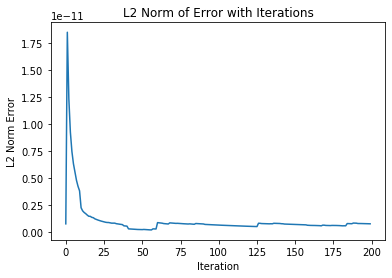

In [9]:
# Create empty array to hold outputs 
iters = 200
x_axis = range(0,iters)
w_temp = np.zeros((iters,real_weights.size))
error_axis = np.zeros(iters)
num_queries = 5

# Obtain "iters" number of weight vector estimation from random data
# Plot the difference with every iteration
for i in x_axis:
    # Generate query data for d+1 (5) inputs
    sepal_lengths = np.random.rand(num_queries)*5 + 0.2
    sepal_widths = np.random.rand(num_queries)*2 + 0.2
    petal_lengths = np.random.rand(num_queries)*5 + 0.2
    petal_widths = np.random.rand(num_queries)*2 + 0.2

    # Generate Pandas Dataframe and use model to predict output
    d = {'sepal length': sepal_lengths, 'sepal width': sepal_widths,'petal length':petal_lengths,'petal width':petal_widths}
    x_test1 = pd.DataFrame(data=d)
    y_test1 = logreg.predict(x_test1)
    conf = logreg.predict_proba(x_test1)[:,1]
    xw_s = get_sigmoid_inv(conf)
    
    # Add bias terms
    x_testvals = np.concatenate((bias, x_test1.values), 1)
    
    w_temp[i,:] = np.linalg.solve(x_testvals,xw_s)
    
    # Obtain Average and difference
    w_avg = np.sum(w_temp, axis=0)/(i+1)
    w_diff = np.sum([real_weights,-1*w_avg],axis=0)
    error_axis[i] = np.linalg.norm(w_diff,ord=2)

plt.plot(x_axis,error_axis)
plt.title("L2 Norm of Error with Iterations")
plt.xlabel("Iteration")
plt.ylabel("L2 Norm Error")

In [10]:
np.mean(error_axis)

1.0445405696511774e-12

In [11]:
w_avg

array([-0.23649762, -0.38897155, -1.31781989,  2.06492322,  0.90383684])

In [12]:
real_weights

array([-0.23649762, -0.38897155, -1.31781989,  2.06492322,  0.90383684])